In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


### Preparing custom images data for training

In [2]:
train_dir = './data/train'
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

In [3]:
df.head()

,filename,category
0,cat.9254.jpg,0
1,dog.5704.jpg,1
2,dog.1646.jpg,1
3,dog.10039.jpg,1
4,cat.1400.jpg,0


### See random image

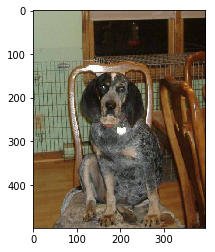

In [4]:
random_img = random.choice(filenames)
img = Image.open(os.path.join(train_dir, random_img))
plt.imshow(img)

### Typical input image size for CNN training is 224x224, 227x227

In [5]:
IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
FAST_RUN = False
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [8]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [9]:
df.head()

,filename,category
0,cat.9254.jpg,cat
1,dog.5704.jpg,dog
2,dog.1646.jpg,dog
3,dog.10039.jpg,dog
4,cat.1400.jpg,cat


In [10]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [11]:
train_df.shape

(20000, 2)

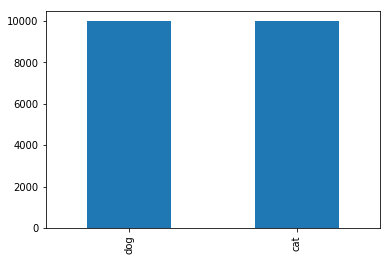

In [12]:
train_df.shape
train_df['category'].value_counts().plot.bar()
validate_df['category'].value_counts().plot.bar()

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Traning Generator

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


### Validation Generator

In [15]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 5000 images belonging to 2 classes.


### See how our generator work

In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 images belonging to 1 classes.


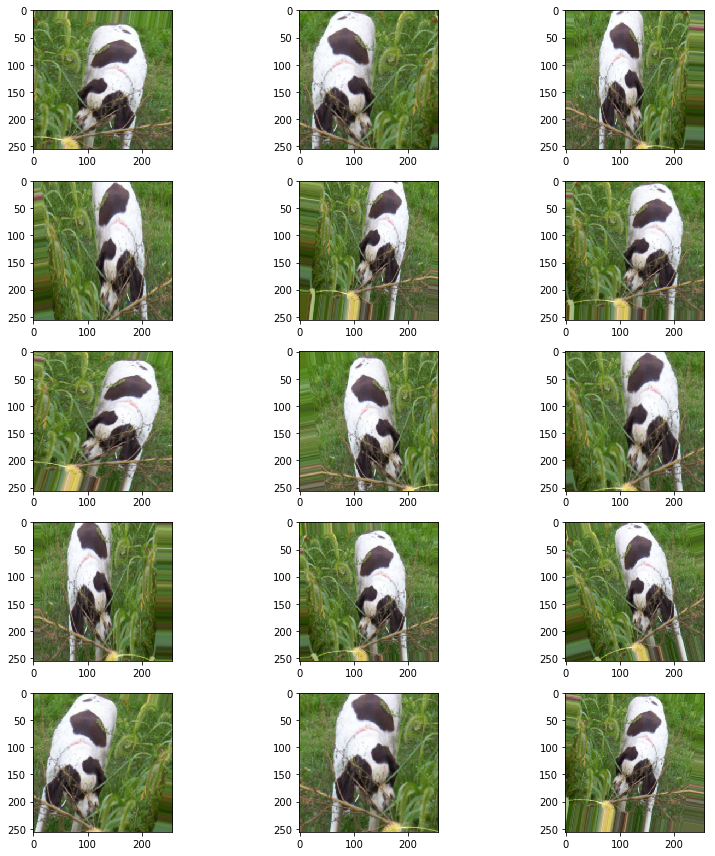

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
from IPython.display import display
from PIL import Image

epochs=3 if FAST_RUN else 50
print(epochs)
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

50
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1333/1333 [==============================] - 211s 158ms/step - loss: 0.7602 - acc: 0.6297 - val_loss: 0.6063 - val_acc: 0.6807
Epoch 2/50
1333/1333 [==============================] - 208s 156ms/step - loss: 0.5772 - acc: 0.7085 - val_loss: 1.0160 - val_acc: 0.5422
Epoch 3/50
1333/1333 [==============================] - 208s 156ms/step - loss: 0.5133 - acc: 0.7549 - val_loss: 0.7861 - val_acc: 0.6046

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/50
1333/1333 [==============================] - 208s 156ms/step - loss: 0.4522 - acc: 0.7889 - val_loss: 0.3764 - val_acc: 0.8351
Epoch 5/50
1333/1333 [==============================] - 207s 156ms/step - loss: 0.4231 - acc: 0.8066 - val_loss: 0.4031 - val_acc: 0.8239
Epoch 6/50
1333/1333 [==============================] - 207s 155ms/step - loss: 0.4076 - acc: 0.8176 - val_loss: 0.6179 - val_acc: 0.6967

Epoch 00006: ReduceLROnPlateau reducing

## Saving only the Architecture without weights

In [26]:
if not os.path.isdir('./models'): os.mkdir('./models')
model_json = model.to_json()
with open('./models/model_arc.json', 'w') as json_file:
    json_file.write(model_json)

## Saving weights

In [27]:
model.save_weights('./models/model_weights.h5')

## Saving Model (Architecure + weights + Training configuration + optimizer)
### And it allows resume training exactly where you left off

In [28]:
model.save('./models/model_clf.h5')

## Prediction using saved Model

In [30]:
from keras.models import load_model
clf_model = load_model('./models/model_clf.h5')

In [31]:
clf_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
__________

## Virtualize Training

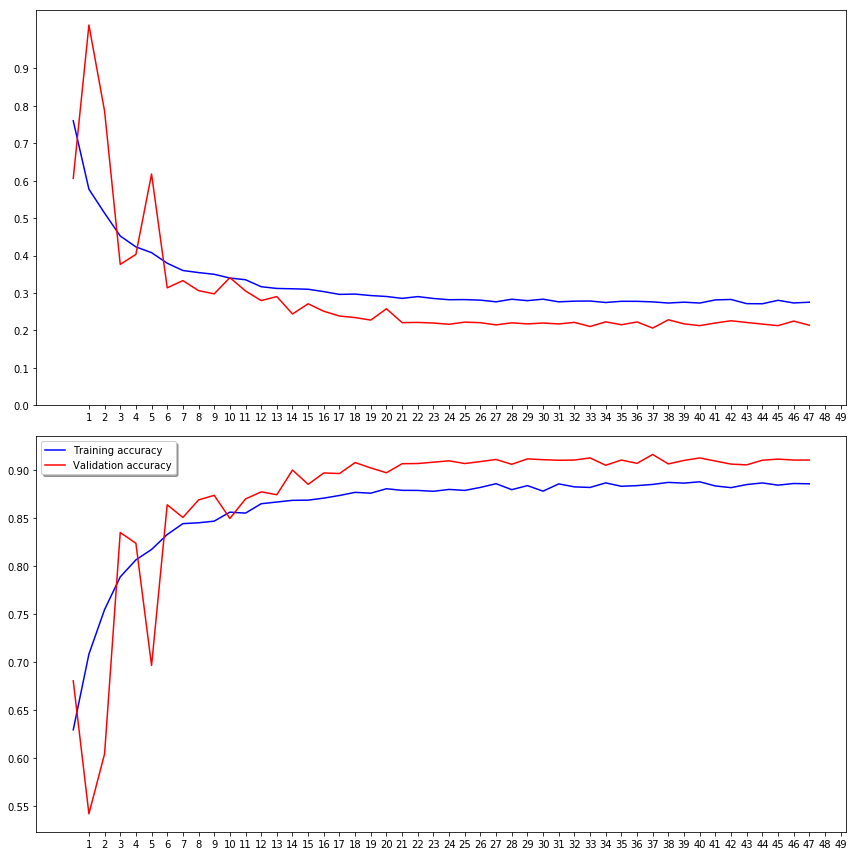

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Preparing Test data

In [33]:
test_dir = './data/test'
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(test_df.shape)
test_df.head()

(12500, 1)


,filename
0,1821.jpg
1,2292.jpg
2,10101.jpg
3,607.jpg
4,2670.jpg


## Creating Testing Generator

In [34]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


## Predict

In [35]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [36]:
predict

array([[2.0999198e-04, 9.9979001e-01],
       [9.9977237e-01, 2.2762796e-04],
       [5.2217234e-02, 9.4778275e-01],
       ...,
       [9.4720834e-01, 5.2791603e-02],
       [9.2595756e-01, 7.4042432e-02],
       [1.6291250e-01, 8.3708751e-01]], dtype=float32)

In [37]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df.head()

,filename,category
0,1821.jpg,1
1,2292.jpg,0
2,10101.jpg,1
3,607.jpg,1
4,2670.jpg,0


In [38]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df["category"] = test_df["category"].replace({0: 'cat', 1: 'dog'})

test_df.head()

,filename,category
0,1821.jpg,dog
1,2292.jpg,cat
2,10101.jpg,dog
3,607.jpg,dog
4,2670.jpg,cat


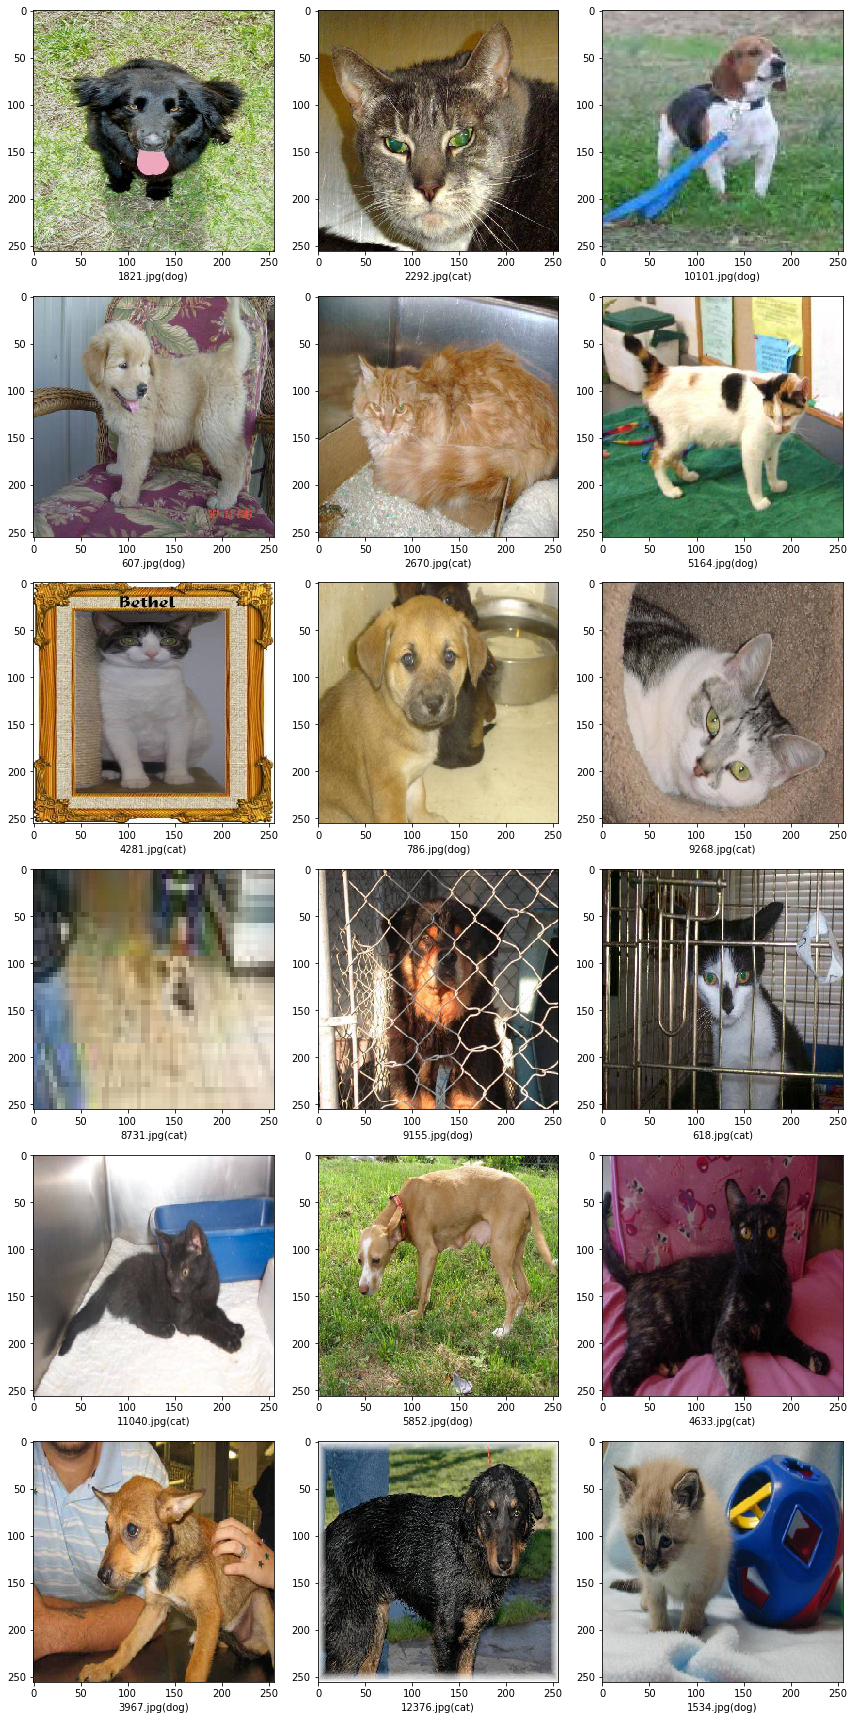

In [39]:
from keras.preprocessing import image

sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = image.load_img(test_dir + "/" + filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()